In [48]:
import pandas as pd                                       #importing pandas
import numpy as np                                        #importing numpy
import matplotlib.pyplot as plt                           #importing matplotlib 
import seaborn as sns                                     #importing seaborn
from sklearn.model_selection import train_test_split      #importing scikit-learn's function for data splitting
from sklearn.linear_model import LinearRegression         #importing scikit-learn's linear regressor function
from sklearn.neural_network import MLPRegressor           #importing scikit-learn's neural network function
from sklearn.ensemble import GradientBoostingRegressor    #importing scikit-learn's gradient booster regressor function
from sklearn.metrics import mean_squared_error            #importing scikit-learn's root mean squared error function for model evaluation
from sklearn.model_selection import cross_validate        #improting scikit-learn's cross validation function
import random
import time
from tqdm import tqdm
from scipy.stats import ks_2samp, kruskal

In [49]:
boxscores = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/boxscores_dataset.csv')     #load boxscores dataset
# running locally
# boxscores = pd.read_csv('boxscores_dataset.csv')     #load boxscores dataset
boxscores = boxscores[(boxscores.playMin>=3) | (boxscores.playMin.isnull())]

Text(134.875, 0.5, 'Fantasy Points')

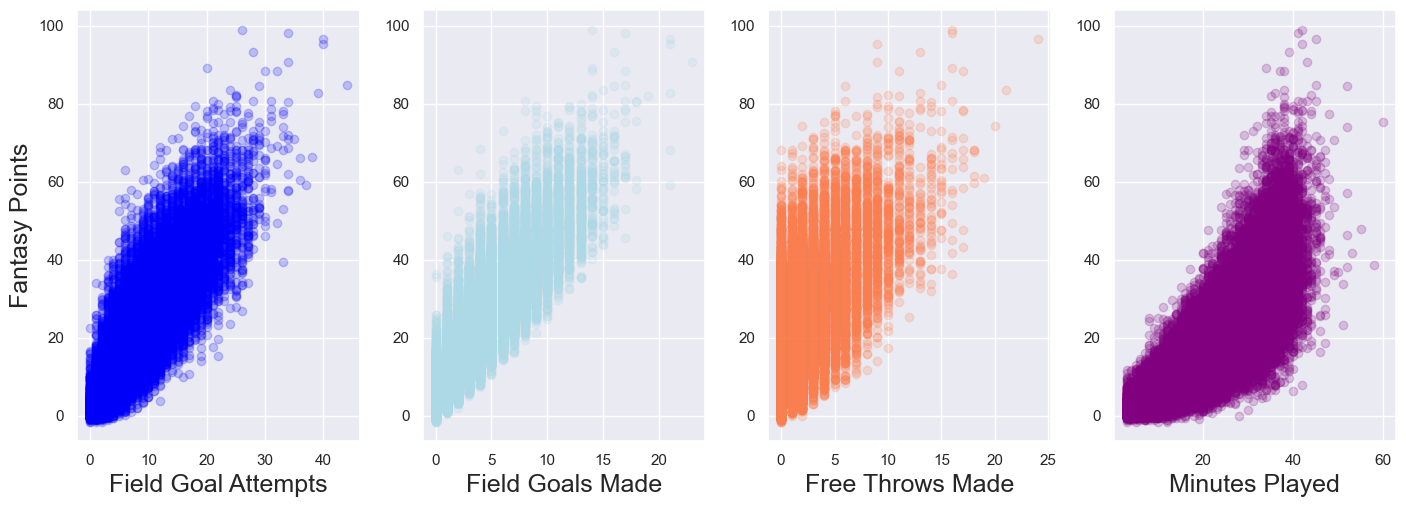

In [50]:
fig, (FGA, FGM, FTM, Min) = plt.subplots(1, 4, figsize=(14,5))
fig.tight_layout()

FGA.scatter(boxscores['playFGA'], boxscores['FantasyPoints'], c='blue', alpha = .2)
FGM.scatter(boxscores['playFGM'], boxscores['FantasyPoints'], c='lightblue', alpha = .2)
FTM.scatter(boxscores['playFTM'], boxscores['FantasyPoints'], c='coral', alpha = .2)
Min.scatter(boxscores['playMin'], boxscores['FantasyPoints'], c='purple', alpha = .2)

FGA.set_xlabel('Field Goal Attempts', fontsize = 18)
FGM.set_xlabel('Field Goals Made', fontsize = 18)
FTM.set_xlabel('Free Throws Made', fontsize = 18)
Min.set_xlabel('Minutes Played', fontsize = 18)

FGA.set_ylabel('Fantasy Points', fontsize = 18)

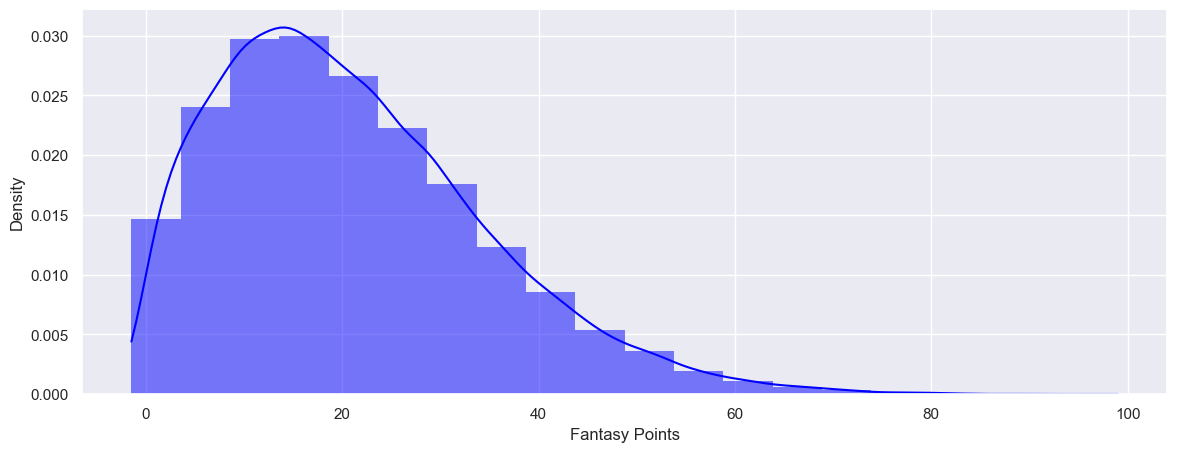

In [51]:
hplot = sns.histplot(boxscores['FantasyPoints'], color="blue", label="Fantasy Points", kde=True, stat="density", linewidth=0, bins=20)
hplot.set_xlabel("Fantasy Points", fontsize = 12)
hplot.set_ylabel("Density", fontsize = 12)
sns.set(rc={"figure.figsize":(14, 5)})

In [52]:
horizon=3

for column_name in ['playPTS','playAST','playTO','playSTL','playBLK','playTRB','playFGA','playFTA','play2P%','play3P%','playFT%','playMin','teamDayOff','FantasyPoints']:
    boxscores['moving' + column_name] = boxscores.groupby(['playDispNm'])[column_name].transform(lambda x: x.rolling(horizon, 1).mean().shift(1))
print(boxscores)

       Unnamed: 0      gmDate gmTime  seasTyp  playLNm    playFNm teamAbbr  \
0             226  2016-10-26   8:00  Regular  Abrines  Alejandro      OKC   
2            1382  2016-11-02  10:30  Regular  Abrines  Alejandro      OKC   
3            1492  2016-11-03  10:30  Regular  Abrines  Alejandro      OKC   
4            1724  2016-11-05   6:00  Regular  Abrines  Alejandro      OKC   
5            2130  2016-11-07   8:00  Regular  Abrines  Alejandro      OKC   
...           ...         ...    ...      ...      ...        ...      ...   
36752       23335  2017-03-26   9:30  Regular    Zubac      Ivica      LAL   
36753       23622  2017-03-28  10:30  Regular    Zubac      Ivica      LAL   
36756       29682  2017-11-09   7:00  Regular    Zubac      Ivica      LAL   
36758       31582  2017-11-21  10:30  Regular    Zubac      Ivica      LAL   
36760       33441  2017-12-03   9:30  Regular    Zubac      Ivica      LAL   

      teamConf    teamDiv teamLoc  ... movingplayBLK  movingpla

In [53]:
boxscores.dropna(subset = ["movingplayPTS"], inplace=True)  

In [55]:
print(boxscores)

       Unnamed: 0      gmDate gmTime  seasTyp  playLNm    playFNm teamAbbr  \
2            1382  2016-11-02  10:30  Regular  Abrines  Alejandro      OKC   
3            1492  2016-11-03  10:30  Regular  Abrines  Alejandro      OKC   
4            1724  2016-11-05   6:00  Regular  Abrines  Alejandro      OKC   
5            2130  2016-11-07   8:00  Regular  Abrines  Alejandro      OKC   
6            2447  2016-11-09   8:00  Regular  Abrines  Alejandro      OKC   
...           ...         ...    ...      ...      ...        ...      ...   
36752       23335  2017-03-26   9:30  Regular    Zubac      Ivica      LAL   
36753       23622  2017-03-28  10:30  Regular    Zubac      Ivica      LAL   
36756       29682  2017-11-09   7:00  Regular    Zubac      Ivica      LAL   
36758       31582  2017-11-21  10:30  Regular    Zubac      Ivica      LAL   
36760       33441  2017-12-03   9:30  Regular    Zubac      Ivica      LAL   

      teamConf    teamDiv teamLoc  ... movingplayBLK  movingpla

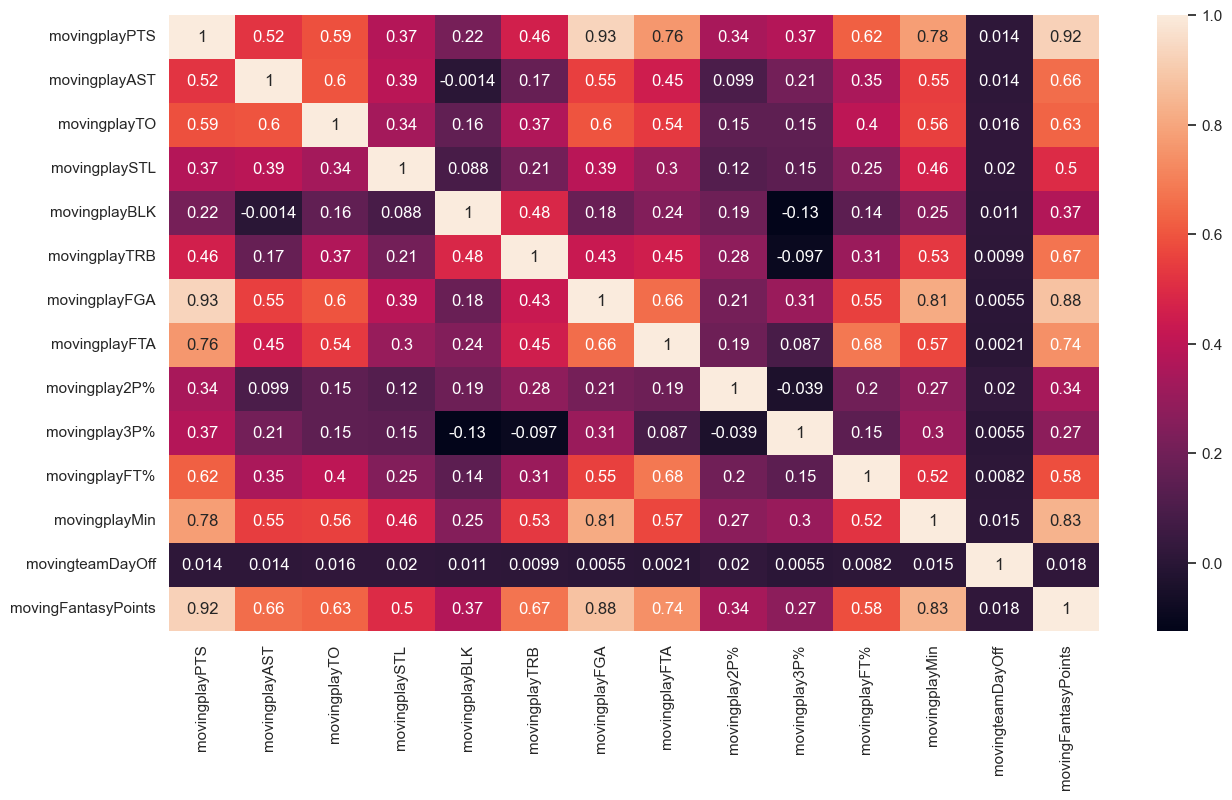

In [56]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(boxscores[['movingplayPTS', 'movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFGA','movingplayFTA','movingplay2P%','movingplay3P%','movingplayFT%','movingplayMin','movingteamDayOff','movingFantasyPoints']].corr(),annot=True)
plt.show()

In [57]:
boxscores['dummyTeamLoc'] = pd.get_dummies(data=boxscores['teamLoc'],drop_first=True)    #1 if the game is a home game, 0 if it is an away game
boxscores['dummyplayStat'] = pd.get_dummies(data=boxscores['playStat'],drop_first=True)  #1 if the player starts, 0 if the player comes from the bench

In [58]:
forecasting_data = boxscores[boxscores.gmDate != '2017-12-25']  #for model training, we exclude observation on December 25, 2017

In [59]:
X = forecasting_data[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]  #select the features that will be used for model training
y = forecasting_data['FantasyPoints']  #target set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)      #dataset splitting

linear_regressor = LinearRegression()                                                         #load linear regressor
linear_regressor.fit(X_train, y_train)                                                        #train the linear regression model
linear_regression_validation = cross_validate(linear_regressor, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

mlp = MLPRegressor(hidden_layer_sizes=(5,5), activation='relu')                               #load neural network
mlp.fit(X_train,y_train)                                                                      #train the neural network with a ReLU function and two hidden layers with 5 nodes each
mlp_validation = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

gb = GradientBoostingRegressor()                                                              #load a gradient boosting regressor
gb.fit(X_train, y_train)                                                                      #train a gradient boosting model
gb_validation = cross_validate(gb, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

c:\Users\mar\anaconda3\envs\tfg\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [60]:
gb_validation['test_score']  

array([0.50955046, 0.49926381, 0.48126321, 0.49749127, 0.50065966])

In [61]:
linear_regression_predictions = linear_regressor.predict(X_test)                              #make predictions based on the test set for the linear regression model
mlp_predictions = mlp.predict(X_test)                                                         #make predictions based on the test set for the neural network model
gb_predictions = gb.predict(X_test)                                                           #make predictions based on the test set for the gradient boosting model

linear_regression_mse = mean_squared_error(y_test, linear_regression_predictions)             #calculate the MSE for the linear regression model
mlp_mse = mean_squared_error(y_test, mlp_predictions)                                         #calculate the MSE for the neural network model
gb_mse = mean_squared_error(y_test, gb_predictions)                                           #calculate the MSE for the gradient boosting model

results = {'Linear Regression':[linear_regression_mse],'ReLU Neural Network':[mlp_mse],'Gradient Boosting Regressor':[gb_mse]}
modeling_results = pd.DataFrame(data=results,index=['MSE'])

modeling_results

,Linear Regression,ReLU Neural Network,Gradient Boosting Regressor
MSE,91.077312,90.962056,90.669672


Text(967.9632352941177, 0.5, 'Gradient Boosting Residual')

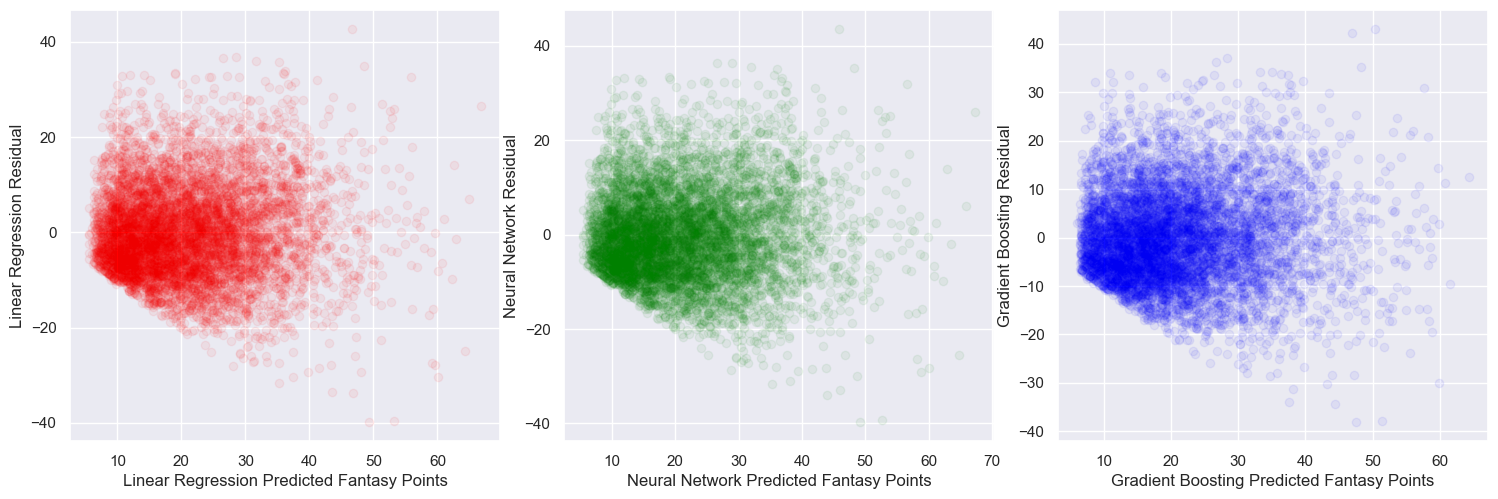

In [62]:
fig, (LR, FNN, GBR) = plt.subplots(1, 3,figsize=(15,5));
fig.tight_layout()

LR.scatter(x = linear_regression_predictions, y = y_test - linear_regression_predictions,color='red',alpha=0.06)
FNN.scatter(x = mlp_predictions, y = y_test - mlp_predictions, color='green',alpha=0.06)
GBR.scatter(x = gb_predictions, y = y_test - gb_predictions, color='blue',alpha=0.06)

LR.set_xlabel('Linear Regression Predicted Fantasy Points')
FNN.set_xlabel('Neural Network Predicted Fantasy Points')
GBR.set_xlabel('Gradient Boosting Predicted Fantasy Points')

LR.set_ylabel('Linear Regression Residual')
FNN.set_ylabel('Neural Network Residual')
GBR.set_ylabel('Gradient Boosting Residual')

In [63]:
gb_final = GradientBoostingRegressor(random_state=4)                                                             
gb_final.fit(X, y)   

optimization_dataset = boxscores
optimization_dataset['PredictedFantasyPoints'] = gb_final.predict(boxscores[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]) 

player_results = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/target_games.csv')
# player_results = pd.read_csv('target_games.csv')

predicted_fantasy_points = (
    optimization_dataset.query("gmDate == '2017-12-25'")
    [["playDispNm", "PredictedFantasyPoints"]]
)

player_results = pd.merge(
    left = player_results,
    right = predicted_fantasy_points,
    left_on = "Player",
    right_on = "playDispNm",
)

In [64]:
print(player_results)

               Player Pos Team     Opp  Salary         playDispNm  \
0        James Harden  PG  HOU   @ OKC   11100       James Harden   
1        LeBron James  SF  CLE   @ GSW   11000       LeBron James   
2   Russell Westbrook  PG  OKC  vs HOU   10900  Russell Westbrook   
3        Kevin Durant  SF  GSW  vs CLE   10500       Kevin Durant   
4         Joel Embiid   C  PHI   @ NYK    9500        Joel Embiid   
..                ...  ..  ...     ...     ...                ...   
91       Andrew Bogut   C  LAL  vs MIN    3000       Andrew Bogut   
92        Alex Caruso  PG  LAL  vs MIN    3000        Alex Caruso   
93      Briante Weber  PG  HOU   @ OKC    3000      Briante Weber   
94         Cedi Osman  SG  CLE   @ GSW    3000         Cedi Osman   
95       Josh Huestis  SF  OKC  vs HOU    3000       Josh Huestis   

    PredictedFantasyPoints  
0                48.809577  
1                48.149718  
2                44.007224  
3                43.438575  
4                51.313689

In [65]:
pd.set_option('display.expand_frame_repr', False)
player_results['Points/Salary Ratio'] = 1000*player_results['PredictedFantasyPoints']/player_results['Salary']    #we multiple the fantasy vs salary ratio by 1000 for better visualization
player_results.sort_values(by='PredictedFantasyPoints',ascending=False).head(5)

,Player,Pos,Team,Opp,Salary,playDispNm,PredictedFantasyPoints,Points/Salary Ratio
4,Joel Embiid,C,PHI,@ NYK,9500,Joel Embiid,51.313689,5.401441
0,James Harden,PG,HOU,@ OKC,11100,James Harden,48.809577,4.397259
1,LeBron James,SF,CLE,@ GSW,11000,LeBron James,48.149718,4.377247
2,Russell Westbrook,PG,OKC,vs HOU,10900,Russell Westbrook,44.007224,4.037360
3,Kevin Durant,SF,GSW,vs CLE,10500,Kevin Durant,43.438575,4.137007


In [66]:
indices = player_results.Player
points = dict(zip(indices, player_results.PredictedFantasyPoints))
salaries = dict(zip(indices, player_results.Salary))
S = 30000
positions = dict(zip(indices, player_results.Pos))

In [67]:
# Lista de posiciones que deben ser cubiertas en cada equipo
posiciones = ["C", "PG", "SG", "SF", "PF"] 
# Crear un diccionario con los jugadores agrupados por posición
jugadores_por_posicion = {pos: [nombre for nombre in indices if positions[nombre] == pos] 
                          for pos in posiciones}

## Definimos los parámetros

In [81]:
#número máximo de iteraciones (itera)
num_generaciones = 400
#tamaño de la población
tamanoPoblacion= 100
#tasa mutación
mu=0.2
# porcentaje de cruzamiento
pc = 0.3
# numero de hijos descencientes (nc)
num_equipos = 50
#número de descendientes mutados
nm=round(0.3*num_equipos)   

In [82]:
# Lo ponemos en 600. Así si el experimento termina puede ser porque
# la población es demasiado pequeña y no se llega al valor óptimo
# la población es demasiado grande y el tiempo de ejecución entra
# en juego
num_generaciones = 75

#tamaño de la población
pc = 0.3

#tamaño de la población
tamano_poblacion = 250

# Número de muestras para cada tamaño de población
num_pruebas = 50  

# porcentaje de cruzamiento
mu_values = 0.3

## Definimos las funciones

### Fitness
Aquí ya iría incluido el límite de que el salario no puede ser mayor que S, así que no lo tenemos que tener en cuenta más tarde

In [74]:
def calcular_fitness(row):
    """
    Calcula el fitness de un equipo basado en la suma de los puntos de los jugadores seleccionados.
    Penaliza si el presupuesto excede el máximo permitido.
    """
    puntos_totales = 0
    salario_total = 0
    
    for pos in posiciones:
        jugador = row[pos]  # Obtiene el nombre del jugador en la posición 'pos'
        puntos_totales += points[jugador]  # Suma los puntos del jugador
        salario_total += salaries[jugador]  # Suma el salario del jugador
    
    if salario_total > S:
        return 0  # Penalización si el equipo excede el presupuesto
    else:
        return puntos_totales

### Creacion la población

In [75]:
def creacion_poblacion(tamanoPoblacion):
    """
    Crea una población de equipos con jugadores aleatorios asignados a cada posición.
    """
    # Crear el DataFrame de la población
    pob = pd.DataFrame(index=range(tamanoPoblacion))
    pob['Equipo'] = range(0, tamanoPoblacion)
    
    # Asignar jugadores aleatorios a cada posición en el equipo
    for pos in posiciones:
        pob[pos] = [random.choice(jugadores_por_posicion[pos]) for _ in range(tamanoPoblacion)]
    
    # Calcular el fitness de cada equipo
    pob['Fitness'] = pob.apply(calcular_fitness, axis=1)
    
    return pob

### Seleccion
Más cómodo que como estaba implementada con cumsum, que también está basada en ruleta

In [76]:
def seleccion_ruleta(poblacion_df):
    """
    Selecciona dos padres basados en el fitness (ruleta).
    
    input:
        param poblacion_df: DataFrame que contiene la población de equipos
    output: 
        Dos padres seleccionados de la población
    """
    fitness_vals = poblacion_df["Fitness"].values
    total_fitness = sum(fitness_vals)

    if total_fitness == 0:
        return poblacion_df.sample(n=2).iloc[:2].to_dict("records")  # Evita división por cero y selecciona aleatoriamente

    # Calcular las probabilidades basadas en el fitness
    probabilidades = [f / total_fitness for f in fitness_vals]

    # Selección del primer padre
    padre_1 = poblacion_df.sample(n=1, weights=probabilidades).iloc[0]

    # Selección del segundo padre
    padre_2 = poblacion_df.sample(n=1, weights=probabilidades).iloc[0]

    return padre_1, padre_2

### Cruce: intercambiar jugadores

In [77]:
def cruce(padre1, padre2, pc):
    """
    Intercambia jugadores entre los padres.
    """
    hijo1, hijo2 = padre1.copy(), padre2.copy()

    for pos in posiciones:
        if random.random() > pc:  
            if points[hijo1[pos]] > points[hijo2[pos]]:
                hijo2[pos] = hijo1[pos]
            else:
                hijo1[pos] = hijo2[pos]
    
    return hijo1, hijo2


### Mutación: cambiar un jugador aleatoriamente

In [78]:
def mutacion(equipo,mu):
    """
    Cambia aleatoriamente un jugador en una posición con probabilidad tasa_mutacion.
    """
    for pos in posiciones:
        if random.random() < mu:
            equipo[pos] = random.choice(jugadores_por_posicion[pos]) 
    
    return equipo


## Implementación GA

In [83]:
# Inicialización de la población
poblacion_df = creacion_poblacion(tamanoPoblacion)

# Bucle principal
for gen in range(num_generaciones):
    
    # Hacer una copia de la población para trabajar en ella sin alterar la original
    #P = poblacion_df.copy()
    nueva_poblacion = []
    
    # Realizar cruce para obtener nuevos hijos
    for j in range(num_equipos // 2):  # Cruce en pares
        # Selección de los padres
        padre1, padre2 = seleccion_ruleta(poblacion_df)
        
        # Realización del cruce
        hijo1, hijo2 = cruce(padre1, padre2, pc)

        # Calcular el fitness de los hijos
        hijo1['Fitness'] = calcular_fitness(hijo1)
        hijo2['Fitness'] = calcular_fitness(hijo2)

        nueva_poblacion.append(hijo1)
        nueva_poblacion.append(hijo2)
        

    # Aplicar la mutación a una fracción de la población
    for k in range(nm):
        z = random.randint(0, len(nueva_poblacion)-1)
        hijo_mutado = mutacion(nueva_poblacion[z].copy(),mu)
        hijo_mutado['Fitness'] = calcular_fitness(hijo_mutado)
        nueva_poblacion[z] = hijo_mutado
        
    # Convertir la lista de nueva población a un DataFrame
    nueva_poblacion_df = pd.DataFrame(nueva_poblacion)
    
    # Concatenar la nueva población con la población existente (actualizar poblacion_df)
    poblacion_df = pd.concat([poblacion_df, nueva_poblacion_df], ignore_index=True)
    
    poblacion_df = poblacion_df.sort_values(by="Fitness", ascending=False)
    
    # Cogemos los 50 primeros de la pob ordenada y de Costs (fitness ordenado)
    # Otra forma sería que los hijos reemplacen a los padres
    poblacion_df=poblacion_df.iloc[0:tamanoPoblacion]
    
    mejor = poblacion_df.iloc[0]

# Mostrar el mejor equipo encontrado
mejor_equipo = poblacion_df.sort_values(by="Fitness", ascending=False).iloc[0]
print("Mejor equipo encontrado:\n", mejor_equipo)

Mejor equipo encontrado:
 Equipo                  90
C              Joel Embiid
PG            Jarrett Jack
SG            Trevor Ariza
SF         Markieff Morris
PF             Dario Saric
Fitness         171.918929
Name: 0, dtype: object


## Resultado final

In [84]:
print("\nEquipo óptimo seleccionado:")
for pos in posiciones:
    jugador = mejor_equipo[pos]
    print(f"{jugador} - Posición: {pos}, FantasyPoints: {points[jugador]}, Salary: {salaries[jugador]}")


Equipo óptimo seleccionado:
Joel Embiid - Posición: C, FantasyPoints: 51.31368913047382, Salary: 9500
Jarrett Jack - Posición: PG, FantasyPoints: 27.780012412781506, Salary: 4600
Trevor Ariza - Posición: SG, FantasyPoints: 26.354156526577885, Salary: 5000
Markieff Morris - Posición: SF, FantasyPoints: 25.96558495634552, Salary: 4400
Dario Saric - Posición: PF, FantasyPoints: 40.5054861101437, Salary: 6200


# Pruebas estadísticas

Comenzamos por el tamaño de la población. Para ello modificaremos el código del bucle principal para realizar los análisis de manera automatizada

Parámetros del experimento:

In [ ]:
# Lo ponemos en 600. Así si el experimento termina puede ser porque
# la población es demasiado pequeña y no se llega al valor óptimo
# la población es demasiado grande y el tiempo de ejecución entra
# en juego
num_generaciones = 600

#tamaño de la población
tamano_poblacion_values = np.linspace(250, 500, 5, dtype=int)

# Número de muestras para cada tamaño de población
num_pruebas = 50  

Ahora el código

In [ ]:
# Almacenamiento de resultados
resultados = []

# Bucle para probar cada tamaño de población
for tamano_poblacion in tamano_poblacion_values:
    for prueba in range(num_pruebas):
        # Inicializar la población
        start_time = time.time()
        poblacion_df = creacion_poblacion(tamano_poblacion)
        
        # Bucle principal de generaciones
        for gen in range(num_generaciones):
            P = poblacion_df.copy()
            nueva_poblacion = []
            
            # Realizar cruce y mutación (como en el código original)
            # Realizar cruce para obtener nuevos hijos
            for j in range(num_equipos // 2):  # Cruce en pares
                # Selección de los padres
                padre1, padre2 = seleccion_ruleta(P)
                
                # Realización del cruce
                hijo1, hijo2 = cruce(padre1, padre2, pc)

                # Calcular el fitness de los hijos
                hijo1['Fitness'] = calcular_fitness(hijo1)
                hijo2['Fitness'] = calcular_fitness(hijo2)

                nueva_poblacion.append(hijo1)
                nueva_poblacion.append(hijo2)
                

            # Aplicar la mutación a una fracción de la población
            for k in range(nm):
                z = random.randint(0, len(nueva_poblacion)-1)
                hijo_mutado = mutacion(nueva_poblacion[z].copy(),mu)
                hijo_mutado['Fitness'] = calcular_fitness(hijo_mutado)
                nueva_poblacion[z] = hijo_mutado
                
            # Convertir la lista de nueva población a un DataFrame
            nueva_poblacion_df = pd.DataFrame(nueva_poblacion)
            
            # Concatenar la nueva población con la población existente (actualizar poblacion_df)
            poblacion_df = pd.concat([poblacion_df, nueva_poblacion_df], ignore_index=True)
            
            poblacion_df = poblacion_df.sort_values(by="Fitness", ascending=False)
            
            # Cogemos los 50 primeros de la pob ordenada y de Costs (fitness ordenado)
            # Otra forma sería que los hijos reemplacen a los padres
            poblacion_df=poblacion_df.iloc[0:tamanoPoblacion]
            
            # Verificar el mejor fitness al final de cada generación
            mejor = poblacion_df.iloc[0]  # Este es el mejor fitness en la generación actual
            
            # Si el fitness alcanzó el valor objetivo, finalizar la iteración
            if mejor['Fitness'] >= 171.918929:  # Solución ideal
                break
        
        # Tiempo de ejecución
        tiempo_ejecucion = time.time() - start_time
        resultados.append({
            'tamano_poblacion': tamano_poblacion,
            'prueba': prueba,
            'mejor_fitness': mejor['Fitness'],
            'iteraciones': gen,
            'tiempo': tiempo_ejecucion
        })

# Convertir los resultados en un DataFrame para análisis posterior
df_resultados = pd.DataFrame(resultados)

# Guardar los resultados en un archivo CSV
df_resultados.to_csv('resultados_tamano_poblacion_150_350_30_50.csv', index=False)

## funcion que reusaremos

In [85]:
def graficos(atributo, csv_file):

    # Cargar los datos
    df_resultados = pd.read_csv(csv_file)

    # Crear la figura con 3 subgráficos
    fig, axs = plt.subplots(1, 3, figsize=(18,6))

    # Tamaño de letra
    title_size = 18
    label_size = 16
    tick_size = 14

    # Gráfico 1: Tamaño población vs Iteraciones
    axs[0].scatter(df_resultados[atributo], df_resultados['iteraciones'], alpha=0.5, s=20)
    axs[0].set_title(f'{atributo} vs Iteraciones', fontsize=title_size)
    axs[0].set_xlabel(atributo, fontsize=label_size)
    axs[0].set_ylabel('Iteraciones', fontsize=label_size)
    axs[0].set_ylim(0, 600)
    axs[0].tick_params(axis='both', labelsize=tick_size)
    axs[0].grid(True)

    # Gráfico 2: Tamaño población vs Tiempo
    axs[1].scatter(df_resultados[atributo], df_resultados['tiempo'], alpha=0.5)
    axs[1].set_title(f'{atributo} vs Tiempo', fontsize=title_size)
    axs[1].set_xlabel(atributo, fontsize=label_size)
    axs[1].set_ylabel('Tiempo', fontsize=label_size)
    axs[1].set_ylim(0, 50)
    axs[1].tick_params(axis='both', labelsize=tick_size)
    axs[1].grid(True)

    # Gráfico 3: Tamaño población vs Mejor fitness
    axs[2].scatter(df_resultados[atributo], df_resultados['mejor_fitness'], alpha=0.5)
    axs[2].set_title(f'{atributo} vs Fitness', fontsize=title_size)
    axs[2].set_xlabel(atributo, fontsize=label_size)
    axs[2].set_ylabel('Fitness', fontsize=label_size)
    axs[2].set_ylim(169, 172)
    axs[2].tick_params(axis='both', labelsize=tick_size)
    axs[2].grid(True)

    # Ajustar el diseño
    plt.tight_layout()
    plt.show()


In [2]:
def tabla(atributo, csv):
    # Leer los datos desde el archivo CSV
    df = pd.read_csv(csv)

    # Cálculos estadísticos por tamaño de población
    estadisticas = df.groupby(atributo).agg(
        media_fitness=('mejor_fitness', 'mean'),
        mediana_fitness=('mejor_fitness', 'median'),
        cuartil_25_fitness=('mejor_fitness', lambda x: x.quantile(0.25)),
        cuartil_75_fitness=('mejor_fitness', lambda x: x.quantile(0.75)),
        media_iteraciones=('iteraciones', 'mean'),
        mediana_iteraciones=('iteraciones', 'median'),
        cuartil_25_iteraciones=('iteraciones', lambda x: x.quantile(0.25)),
        cuartil_75_iteraciones=('iteraciones', lambda x: x.quantile(0.75)),
        media_tiempo=('tiempo', 'mean'),
        mediana_tiempo=('tiempo', 'median'),
        cuartil_25_tiempo=('tiempo', lambda x: x.quantile(0.25)),
        cuartil_75_tiempo=('tiempo', lambda x: x.quantile(0.75))
    )

    # Mostrar las estadísticas
    print("\nEstadísticas por tamaño de población:")
    print(estadisticas)

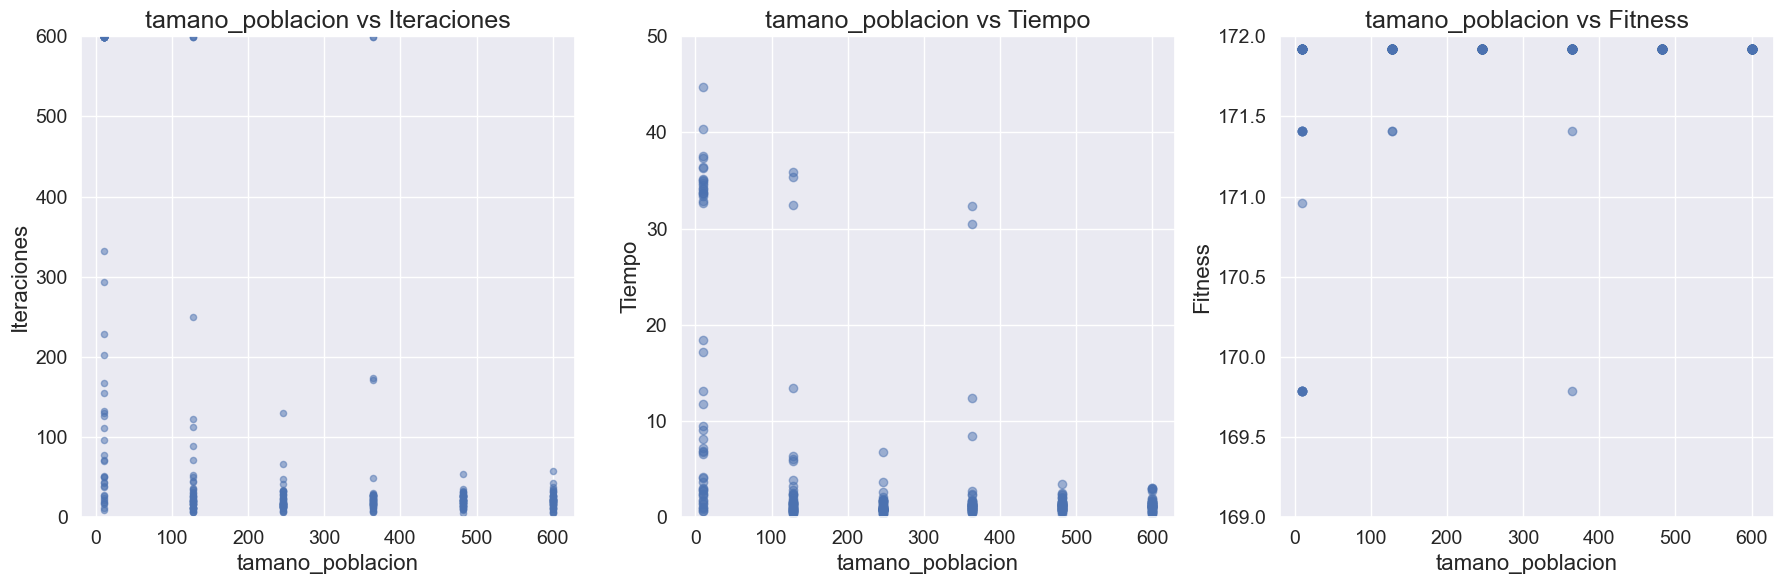

In [86]:
graficos('tamano_poblacion', 'resultados_tamano_poblacion_10_600_30_50.csv')

In [6]:
tabla('tamano_poblacion', 'resultados_tamano_poblacion_10_600_30_2.csv')


Estadísticas por tamaño de población:
                  media_fitness  mediana_fitness  cuartil_25_fitness  \
tamano_poblacion                                                       
10                   171.033474       171.918929          171.105137   
157                  171.780335       171.918929          171.918929   
305                  171.885128       171.918929          171.918929   
452                  171.831036       171.918929          171.918929   
600                  171.780335       171.918929          171.918929   

                  cuartil_75_fitness  media_iteraciones  mediana_iteraciones  \
tamano_poblacion                                                               
10                        171.918929         317.500000                295.0   
157                       171.918929         136.866667                 17.0   
305                       171.918929          59.966667                 15.5   
452                       171.918929          52.566667 

Por lo que el rango ideal parece estar entre 150 y 350

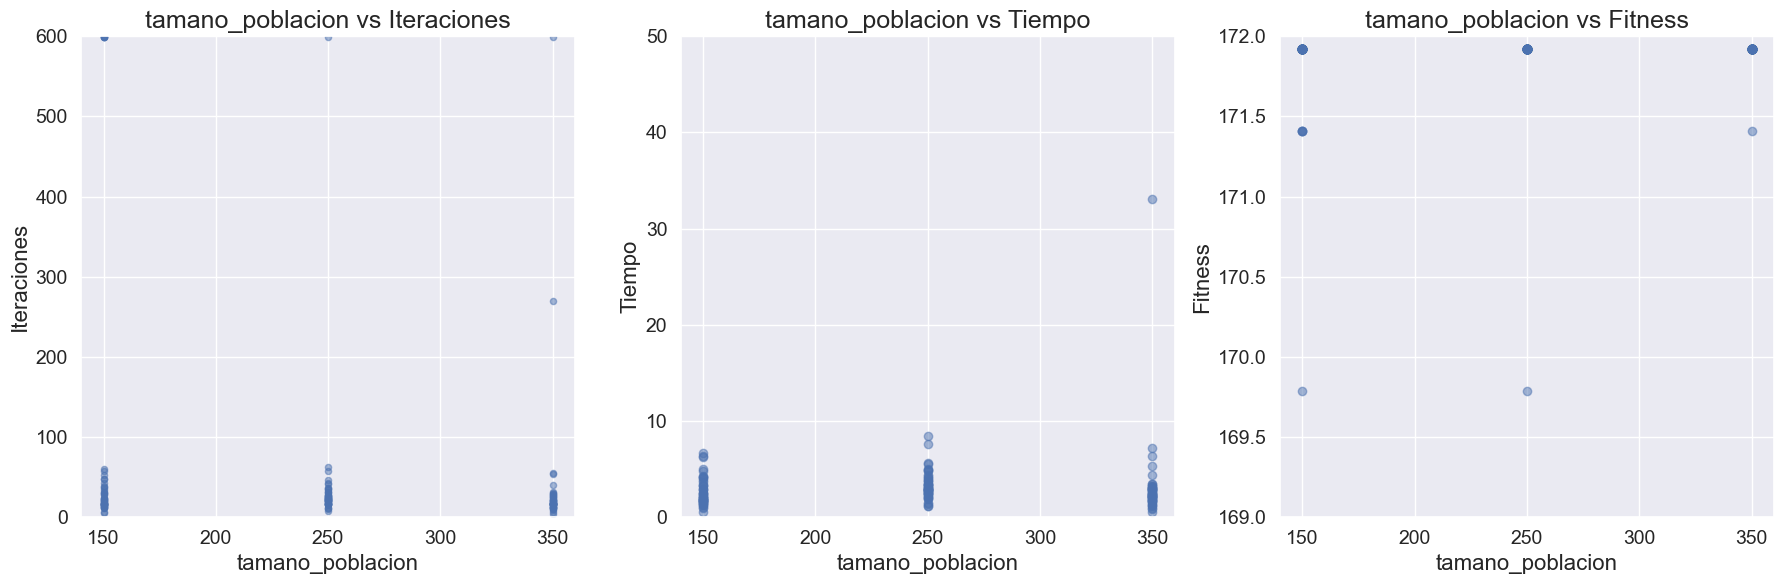

In [88]:
graficos('tamano_poblacion', 'resultados_tamano_poblacion_150_350_30_50.csv')

In [8]:
tabla('tamano_poblacion', 'resultados_tamano_poblacion_150_350_30_50.csv')


Estadísticas por tamaño de población:
                  media_fitness  mediana_fitness  cuartil_25_fitness  \
tamano_poblacion                                                       
150                  171.835773       171.918929          171.918929   
250                  171.876334       171.918929          171.918929   
350                  171.908789       171.918929          171.918929   

                  cuartil_75_fitness  media_iteraciones  mediana_iteraciones  \
tamano_poblacion                                                               
150                       171.918929              81.90                 21.5   
250                       171.918929              36.58                 23.0   
350                       171.918929              36.74                 18.0   

                  cuartil_25_iteraciones  cuartil_75_iteraciones  \
tamano_poblacion                                                   
150                                16.00                   37.7

# Realizamos lo mismo pero para PC, probabilidad de cruzamiento

In [ ]:
# Lo ponemos en 600. Así si el experimento termina puede ser porque
# la población es demasiado pequeña y no se llega al valor óptimo
# la población es demasiado grande y el tiempo de ejecución entra
# en juego
num_generaciones = 600

#tamaño de la población
tamano_poblacion = 250

# Número de muestras para cada tamaño de población
num_pruebas = 50  

# porcentaje de cruzamiento
pc_values = np.linspace(0.01, 0.99, 10, dtype=float)

In [ ]:
# Almacenamiento de resultados
resultados = []

# Bucle para probar cada tamaño de población
for pc in pc_values:
    for prueba in range(num_pruebas):
        # Inicializar la población
        poblacion_df = creacion_poblacion(tamano_poblacion)
        start_time = time.time()
        
        # Bucle principal de generaciones
        for gen in range(num_generaciones):
            P = poblacion_df.copy()
            nueva_poblacion = []
            
            # Realizar cruce y mutación (como en el código original)
            # Realizar cruce para obtener nuevos hijos
            for j in range(num_equipos // 2):  # Cruce en pares
                # Selección de los padres
                padre1, padre2 = seleccion_ruleta(P)
                
                # Realización del cruce
                hijo1, hijo2 = cruce(padre1, padre2, mu)

                # Calcular el fitness de los hijos
                hijo1['Fitness'] = calcular_fitness(hijo1)
                hijo2['Fitness'] = calcular_fitness(hijo2)

                nueva_poblacion.append(hijo1)
                nueva_poblacion.append(hijo2)
                

            # Aplicar la mutación a una fracción de la población
            for k in range(nm):
                z = random.randint(0, len(nueva_poblacion)-1)
                hijo_mutado = mutacion(nueva_poblacion[z].copy(),mu)
                hijo_mutado['Fitness'] = calcular_fitness(hijo_mutado)
                nueva_poblacion[z] = hijo_mutado
                
            # Convertir la lista de nueva población a un DataFrame
            nueva_poblacion_df = pd.DataFrame(nueva_poblacion)
            
            # Concatenar la nueva población con la población existente (actualizar poblacion_df)
            poblacion_df = pd.concat([poblacion_df, nueva_poblacion_df], ignore_index=True)
            
            poblacion_df = poblacion_df.sort_values(by="Fitness", ascending=False)
            
            # Cogemos los 50 primeros de la pob ordenada y de Costs (fitness ordenado)
            # Otra forma sería que los hijos reemplacen a los padres
            poblacion_df=poblacion_df.iloc[0:tamanoPoblacion]
            
            # Verificar el mejor fitness al final de cada generación
            mejor = poblacion_df.iloc[0]  # Este es el mejor fitness en la generación actual
            
            # Si el fitness alcanzó el valor objetivo, finalizar la iteración
            if mejor['Fitness'] >= 171.918929:  # Solución ideal
                break
        
        # Tiempo de ejecución
        tiempo_ejecucion = time.time() - start_time
        resultados.append({
            'pc': pc,
            'prueba': prueba,
            'mejor_fitness': mejor['Fitness'],
            'iteraciones': gen,
            'tiempo': tiempo_ejecucion
        })

# Convertir los resultados en un DataFrame para análisis posterior
df_resultados = pd.DataFrame(resultados)

# Guardar los resultados en un archivo CSV
df_resultados.to_csv('resultados_pc_01_99_10_50_tampob5000.csv', index=False)

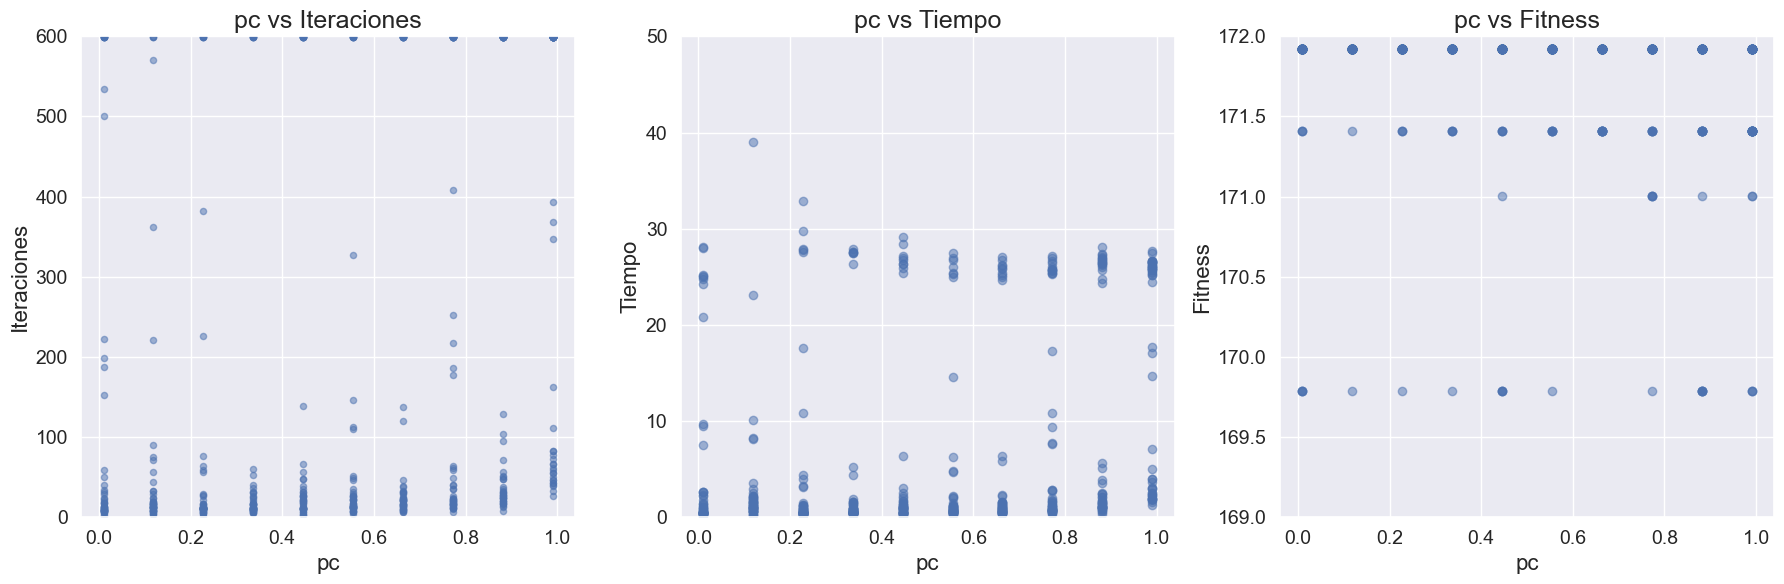

In [89]:
graficos('pc', 'resultados_pc_01_99_10_50.csv')

In [12]:
tabla('pc', 'resultados_pc_01_99_10_50.csv')


Estadísticas por tamaño de población:
          media_fitness  mediana_fitness  cuartil_25_fitness  \
pc                                                             
0.010000     171.643291       171.918929          171.918929   
0.118889     171.781261       171.918929          171.918929   
0.227778     171.760980       171.918929          171.918929   
0.336667     171.773349       171.918929          171.918929   
0.445556     171.689665       171.918929          171.918929   
0.554444     171.815492       171.918929          171.918929   
0.663333     171.817527       171.918929          171.918929   
0.772222     171.619440       171.918929          171.538671   
0.881111     171.543633       171.918929          171.411918   
0.990000     171.195007       171.411918          171.411918   

          cuartil_75_fitness  media_iteraciones  mediana_iteraciones  \
pc                                                                     
0.010000          171.918929             143.38 

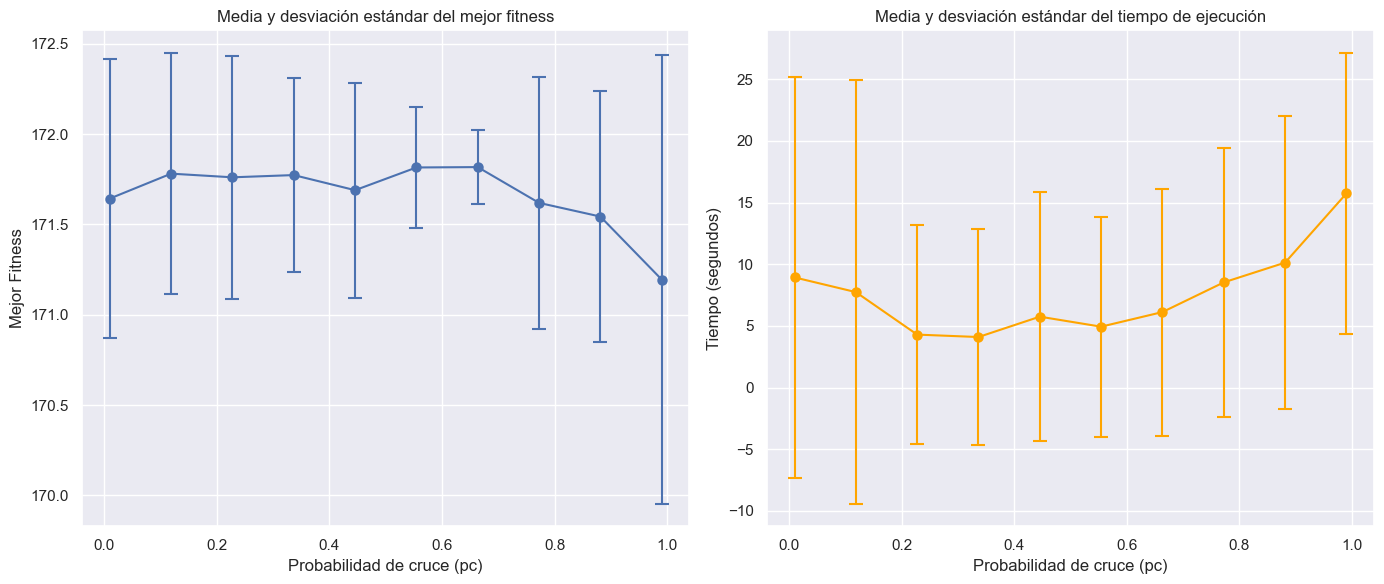

In [93]:
# Cargar los datos
df = pd.read_csv("resultados_pc_01_99_10_50.csv")

# Agrupar por 'pc' y calcular media y desviación estándar del mejor fitness
summary_fitness = df.groupby("pc")["mejor_fitness"].agg(['mean', 'std']).reset_index()

# Agrupar por 'pc' y calcular media y desviación estándar del tiempo de ejecución
summary_time = df.groupby("pc")["tiempo"].agg(['mean', 'std']).reset_index()

# Crear figura con dos subgráficas
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# Gráfica 1: Fitness
axs[0].errorbar(
    summary_fitness["pc"],
    summary_fitness["mean"],
    yerr=summary_fitness["std"],
    fmt='-o',
    capsize=5,
    elinewidth=1.5,
    markeredgewidth=1.5
)
axs[0].set_title("Media y desviación estándar del mejor fitness")
axs[0].set_xlabel("Probabilidad de cruce (pc)")
axs[0].set_ylabel("Mejor Fitness")
axs[0].grid(True)

# Gráfica 2: Tiempo de ejecución
axs[1].errorbar(
    summary_time["pc"],
    summary_time["mean"],
    yerr=summary_time["std"],
    fmt='-o',
    capsize=5,
    elinewidth=1.5,
    markeredgewidth=1.5,
    color='orange'
)
axs[1].set_title("Media y desviación estándar del tiempo de ejecución")
axs[1].set_xlabel("Probabilidad de cruce (pc)")
axs[1].set_ylabel("Tiempo (segundos)")
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Lo mismo pero para mu

In [ ]:
# Lo ponemos en 600. Así si el experimento termina puede ser porque
# la población es demasiado pequeña y no se llega al valor óptimo
# la población es demasiado grande y el tiempo de ejecución entra
# en juego
num_generaciones = 600

#tamaño de la población
pc = 0.3

#tamaño de la población
tamano_poblacion = 250

# Número de muestras para cada tamaño de población
num_pruebas = 50  

# porcentaje de cruzamiento
mu_values = np.linspace(0.01, 0.99, 10, dtype=float)

In [ ]:
# Almacenamiento de resultados
resultados = []

# Bucle para probar cada tamaño de población
for mu in mu_values:
    for prueba in range(num_pruebas):
        # Inicializar la población
        poblacion_df = creacion_poblacion(tamano_poblacion)
        start_time = time.time()
        
        # Bucle principal de generaciones
        for gen in range(num_generaciones):
            P = poblacion_df.copy()
            nueva_poblacion = []
            
            # Realizar cruce y mutación (como en el código original)
            # Realizar cruce para obtener nuevos hijos
            for j in range(num_equipos // 2):  # Cruce en pares
                # Selección de los padres
                padre1, padre2 = seleccion_ruleta(P)
                
                # Realización del cruce
                hijo1, hijo2 = cruce(padre1, padre2, pc)

                # Calcular el fitness de los hijos
                hijo1['Fitness'] = calcular_fitness(hijo1)
                hijo2['Fitness'] = calcular_fitness(hijo2)

                nueva_poblacion.append(hijo1)
                nueva_poblacion.append(hijo2)
                

            # Aplicar la mutación a una fracción de la población
            for k in range(nm):
                z = random.randint(0, len(nueva_poblacion)-1)
                hijo_mutado = mutacion(nueva_poblacion[z].copy(),mu)
                hijo_mutado['Fitness'] = calcular_fitness(hijo_mutado)
                nueva_poblacion[z] = hijo_mutado
                
            # Convertir la lista de nueva población a un DataFrame
            nueva_poblacion_df = pd.DataFrame(nueva_poblacion)
            
            # Concatenar la nueva población con la población existente (actualizar poblacion_df)
            poblacion_df = pd.concat([poblacion_df, nueva_poblacion_df], ignore_index=True)
            
            poblacion_df = poblacion_df.sort_values(by="Fitness", ascending=False)
            
            # Cogemos los 50 primeros de la pob ordenada y de Costs (fitness ordenado)
            # Otra forma sería que los hijos reemplacen a los padres
            poblacion_df=poblacion_df.iloc[0:tamanoPoblacion]
            
            # Verificar el mejor fitness al final de cada generación
            mejor = poblacion_df.iloc[0]  # Este es el mejor fitness en la generación actual
            
            # Si el fitness alcanzó el valor objetivo, finalizar la iteración
            if mejor['Fitness'] >= 171.918929:  # Solución ideal
                break
        
        # Tiempo de ejecución
        tiempo_ejecucion = time.time() - start_time
        resultados.append({
            'mu': mu,
            'prueba': prueba,
            'mejor_fitness': mejor['Fitness'],
            'iteraciones': gen,
            'tiempo': tiempo_ejecucion
        })

# Convertir los resultados en un DataFrame para análisis posterior
df_resultados = pd.DataFrame(resultados)

# Guardar los resultados en un archivo CSV
df_resultados.to_csv('resultados_mu_01_99_10_50.csv', index=False)

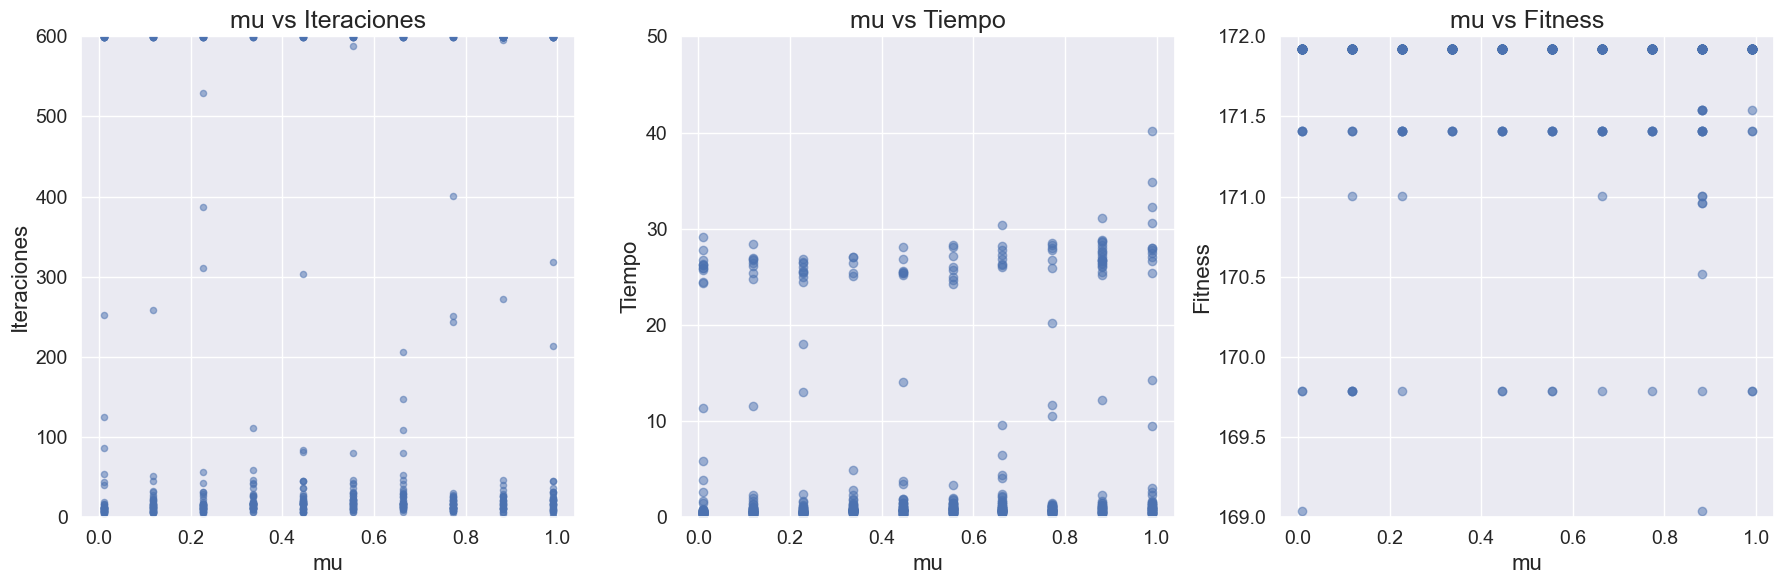

In [90]:
graficos('mu', 'resultados_mu_01_99_10_50.csv')

In [14]:
tabla('mu', 'resultados_mu_01_99_10_50.csv')


Estadísticas por tamaño de población:
          media_fitness  mediana_fitness  cuartil_25_fitness  \
mu                                                             
0.010000     171.363586       171.918929          171.918929   
0.118889     171.699805       171.918929          171.918929   
0.227778     171.797171       171.918929          171.918929   
0.336667     171.815945       171.918929          171.918929   
0.445556     171.783037       171.918929          171.918929   
0.554444     171.783037       171.918929          171.918929   
0.663333     171.797171       171.918929          171.918929   
0.772222     171.825633       171.918929          171.918929   
0.881111     171.494112       171.918929          171.411918   
0.990000     171.334526       171.918929          171.918929   

          cuartil_75_fitness  media_iteraciones  mediana_iteraciones  \
mu                                                                     
0.010000          171.918929             150.56 

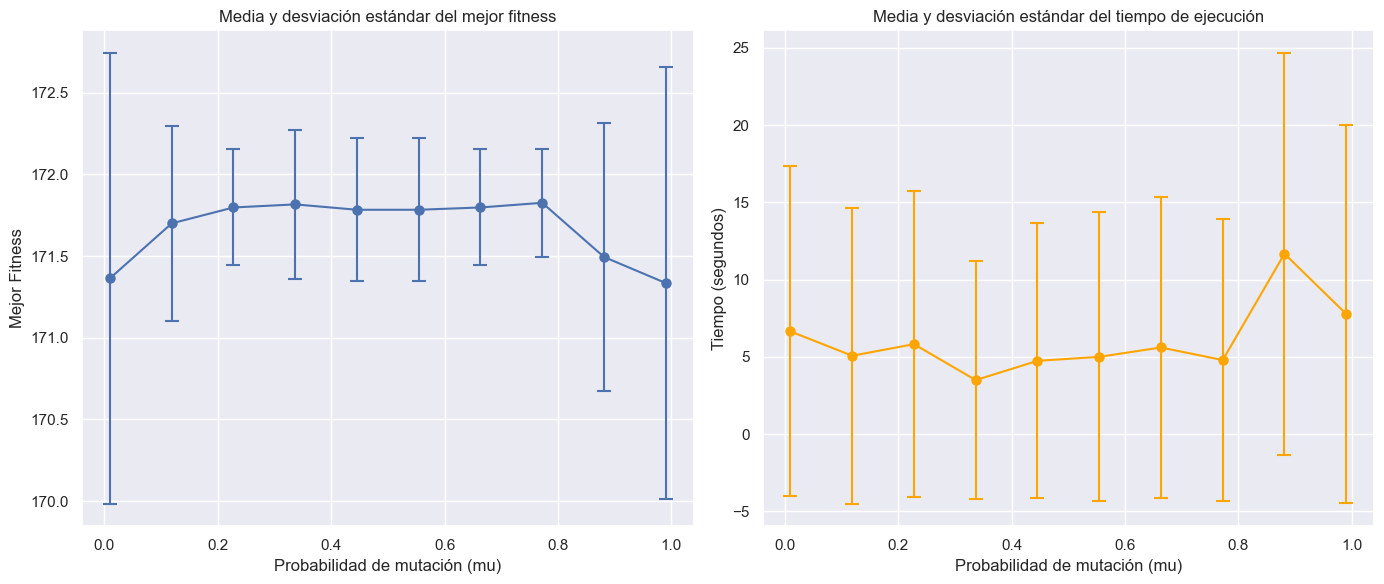

In [94]:
# Cargar los datos
df = pd.read_csv("resultados_mu_01_99_10_50.csv")

# Agrupar por 'pc' y calcular media y desviación estándar del mejor fitness
summary_fitness = df.groupby("mu")["mejor_fitness"].agg(['mean', 'std']).reset_index()

# Agrupar por 'pc' y calcular media y desviación estándar del tiempo de ejecución
summary_time = df.groupby("mu")["tiempo"].agg(['mean', 'std']).reset_index()

# Crear figura con dos subgráficas
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# Gráfica 1: Fitness
axs[0].errorbar(
    summary_fitness["mu"],
    summary_fitness["mean"],
    yerr=summary_fitness["std"],
    fmt='-o',
    capsize=5,
    elinewidth=1.5,
    markeredgewidth=1.5
)
axs[0].set_title("Media y desviación estándar del mejor fitness")
axs[0].set_xlabel("Probabilidad de mutación (mu)")
axs[0].set_ylabel("Mejor Fitness")
axs[0].grid(True)

# Gráfica 2: Tiempo de ejecución
axs[1].errorbar(
    summary_time["mu"],
    summary_time["mean"],
    yerr=summary_time["std"],
    fmt='-o',
    capsize=5,
    elinewidth=1.5,
    markeredgewidth=1.5,
    color='orange'
)
axs[1].set_title("Media y desviación estándar del tiempo de ejecución")
axs[1].set_xlabel("Probabilidad de mutación (mu)")
axs[1].set_ylabel("Tiempo (segundos)")
axs[1].grid(True)

plt.tight_layout()
plt.show()

# PARAMETROS DEFINITIVOS

In [29]:
num_generaciones = 100 # si en 100 no ha convergido al valor exacto no pasa nada, será un valor aproximado

#tamaño de la población
pc = 0.3

#tamaño de la población
tamano_poblacion = 250

# Número de muestras para cada tamaño de población
num_pruebas = 50  

# porcentaje de cruzamiento
mu_values = 0.3

# Estudio estadístico

In [30]:
# Parámetros del algoritmo genético
FITNESS_OBJETIVO = 171.918929  # Valor óptimo conocido
MAX_GENERACIONES = 100          # Máximo de generaciones
MAX_GENERACIONES_SIN_MEJORA = 20 # Generaciones sin mejora para parar
UMBRAL_CONVERGENCIA = 1e-6      # Cambio mínimo para considerar mejora

# Rangos de parámetros a probar (incluyendo valores fuera del rango ideal)
tamano_poblacion_values = np.linspace(50, 650, 7, dtype=int)  # Rango ideal: 250-350
pc_values = np.linspace(0.1, 0.9, 9, dtype=float)      # Rango ideal: 0.15-0.4
mu_values = np.linspace(0.1, 0.9, 9, dtype=float)            # Rango ideal: 0.1-0.4

repeticiones = 30  # Número de ejecuciones por combinación

función para las pruebas

In [31]:
def ejecutar_algoritmo_genetico(tamanoPoblacion, pc, mu):
    # Inicialización
    inicio = time.time()
    poblacion_df = creacion_poblacion(tamanoPoblacion)
    mejor_fitness_historico = -np.inf
    generaciones_sin_mejora = 0
    fitness_history = []
    
    for gen in range(MAX_GENERACIONES):
        # Operadores genéticos
        nueva_poblacion = []
        
        # Cruce
        for _ in range(tamanoPoblacion // 2):
            padre1, padre2 = seleccion_ruleta(poblacion_df)
            hijo1, hijo2 = cruce(padre1, padre2, pc)
            hijo1['Fitness'] = calcular_fitness(hijo1)
            hijo2['Fitness'] = calcular_fitness(hijo2)
            nueva_poblacion.extend([hijo1, hijo2])
        
        # Mutación
        for _ in range(int(mu * tamanoPoblacion)):
            idx = random.randint(0, len(nueva_poblacion)-1)
            nueva_poblacion[idx] = mutacion(nueva_poblacion[idx].copy(), mu)
            nueva_poblacion[idx]['Fitness'] = calcular_fitness(nueva_poblacion[idx])
        
        # Selección de supervivientes
        poblacion_df = pd.concat([poblacion_df, pd.DataFrame(nueva_poblacion)], ignore_index=True)
        poblacion_df = poblacion_df.sort_values(by="Fitness", ascending=False).head(tamanoPoblacion)
        
        # Evaluar criterios de parada
        mejor_actual = poblacion_df.iloc[0]['Fitness']
        fitness_history.append(mejor_actual)
        
        # 1. Comprobar si alcanzamos el óptimo
        if mejor_actual >= FITNESS_OBJETIVO:
            break
            
        # 2. Comprobar estancamiento
        diferencia = abs(mejor_actual - mejor_fitness_historico)
        if diferencia < UMBRAL_CONVERGENCIA:
            generaciones_sin_mejora += 1
        else:
            generaciones_sin_mejora = 0
            
        if generaciones_sin_mejora >= MAX_GENERACIONES_SIN_MEJORA:
            break
            
        mejor_fitness_historico = max(mejor_actual, mejor_fitness_historico)
        
    fin = time.time()
    tiempo_ejecucion = fin - inicio
    
    return {
        "fitness_history": fitness_history,
        "mejor_fitness": mejor_actual,
        "generaciones": gen+1,
        "alcanzo_optimo": mejor_actual >= FITNESS_OBJETIVO,
        "tiempo_ejecucion": tiempo_ejecucion
    }

Análisis de sensibilidad

In [32]:
def analisis_sensibilidad():
    resultados = []
    
    # Función auxiliar para añadir resultados
    def agregar_resultado(param, valor, resultado, rango_ideal):
        resultados.append({
            "Parametro": param,
            "Valor": valor,
            "run": run,
            "mejor_fitness": resultado["mejor_fitness"],
            "tiempo_ejecucion": resultado["tiempo_ejecucion"],
            "generaciones": resultado["generaciones"],
            "alcanzo_optimo": resultado["alcanzo_optimo"],
            "en_rango": "Dentro" if rango_ideal[0] <= valor <= rango_ideal[1] else "Fuera"
        })
    
    # 1. Variar tamaño de población
    print("Variando tamaño de población...")
    for tamanoPoblacion in tqdm(tamano_poblacion_values):
        for run in range(repeticiones):
            resultado = ejecutar_algoritmo_genetico(tamanoPoblacion, 0.3, 0.3)
            agregar_resultado("tamano_poblacion", tamanoPoblacion, resultado, (250, 350))
    
    # 2. Variar probabilidad de cruce
    print("Variando probabilidad de cruce...")
    for pc in tqdm(pc_values):
        for run in range(repeticiones):
            resultado = ejecutar_algoritmo_genetico(250, pc, 0.3)
            agregar_resultado("pc", pc, resultado, (0.2, 0.35))
    
    # 3. Variar tasa de mutación
    print("Variando tasa de mutación...")
    for mu in tqdm(mu_values):
        for run in range(repeticiones):
            resultado = ejecutar_algoritmo_genetico(250, 0.3, mu)
            agregar_resultado("mu", mu, resultado, (0.15, 0.35))
    
    return pd.DataFrame(resultados)

Análisis estadístico 

In [33]:
def analisis_estadistico(df):
    print("\n=== Análisis por Parámetro ===")
    
    for param in ['tamano_poblacion', 'pc', 'mu']:
        print(f"\n---- {param.upper()} ----")
        df_param = df[df['Parametro'] == param]
        
        # Fitness: Dentro vs Fuera del rango
        dentro_fit = df_param[df_param['en_rango'] == 'Dentro']['mejor_fitness']
        fuera_fit = df_param[df_param['en_rango'] == 'Fuera']['mejor_fitness']
        h_fit, p_fit = kruskal(dentro_fit, fuera_fit)
        
        # Tiempo: Dentro vs Fuera del rango
        dentro_tiempo = df_param[df_param['en_rango'] == 'Dentro']['tiempo_ejecucion']
        fuera_tiempo = df_param[df_param['en_rango'] == 'Fuera']['tiempo_ejecucion']
        h_tiempo, p_tiempo = kruskal(dentro_tiempo, fuera_tiempo)
        
        print(f"FITNESS - H: {h_fit:.3f}, p-valor: {p_fit:.4f}")
        print(f"TIEMPO - H: {h_tiempo:.3f}, p-valor: {p_tiempo:.4f}")
        
        # Resumen estadístico
        print("\nResumen estadístico:")
        print(df_param.groupby('en_rango').agg({
            'mejor_fitness': ['mean', 'std'],
            'tiempo_ejecucion': ['mean', 'std'],
            'alcanzo_optimo': 'sum'
        }))


Visualizacion

In [34]:
def visualizacion(df):
    plt.figure(figsize=(18, 12))
    
    # Paleta de colores para 'en_rango'
    palette = {'Dentro': 'lightblue', 'Fuera': 'salmon'}
    
    # ========== GRÁFICOS DE FITNESS ==========
    # Tamaño de población
    plt.subplot(2, 3, 1)
    sns.boxplot(data=df[df['Parametro'] == 'tamano_poblacion'], 
                x='Valor', y='mejor_fitness', hue='en_rango',
                dodge=True, palette=palette, width=0.7)
    plt.title("Fitness - Tamaño Población\n(Línea roja = Óptimo)", fontweight='bold')
    plt.axhline(FITNESS_OBJETIVO, color='red', linestyle='--', linewidth=1.5)
    plt.xlabel("Tamaño de población")
    plt.ylabel("Fitness")
    plt.ylim(168, 172.5)
    plt.grid(axis='y', alpha=0.3)
    
    # Probabilidad de cruce (pc)
    plt.subplot(2, 3, 2)
    ax = sns.boxplot(data=df[df['Parametro'] == 'pc'], 
                    x='Valor', y='mejor_fitness', hue='en_rango',
                    dodge=True, palette=palette, width=0.7)
    plt.title("Fitness - Probabilidad de Cruce\n(Línea roja = Óptimo)", fontweight='bold')
    plt.axhline(FITNESS_OBJETIVO, color='red', linestyle='--', linewidth=1.5)
    plt.xlabel("Probabilidad de cruce (pc)")
    plt.ylabel("")
    plt.ylim(168, 172.5)
    plt.grid(axis='y', alpha=0.3)
    ax.set_xticklabels([f"{float(x.get_text()):.2f}" for x in ax.get_xticklabels()])
    
    # Tasa de mutación (mu)
    plt.subplot(2, 3, 3)
    ax = sns.boxplot(data=df[df['Parametro'] == 'mu'], 
                    x='Valor', y='mejor_fitness', hue='en_rango',
                    dodge=True, palette=palette, width=0.7)
    plt.title("Fitness - Tasa de Mutación\n(Línea roja = Óptimo)", fontweight='bold')
    plt.axhline(FITNESS_OBJETIVO, color='red', linestyle='--', linewidth=1.5)
    plt.xlabel("Tasa de mutación (mu)")
    plt.ylabel("")
    plt.ylim(168, 172.5)
    plt.grid(axis='y', alpha=0.3)
    ax.set_xticklabels([f"{float(x.get_text()):.2f}" for x in ax.get_xticklabels()])
    
    # ========== GRÁFICOS DE TIEMPO ==========
    # Tamaño de población
    plt.subplot(2, 3, 4)
    sns.boxplot(data=df[df['Parametro'] == 'tamano_poblacion'], 
                x='Valor', y='tiempo_ejecucion', hue='en_rango',
                dodge=True, palette=palette, width=0.7)
    plt.title("Tiempo de Ejecución - Tamaño Población", fontweight='bold')
    plt.xlabel("Tamaño de población")
    plt.ylabel("Tiempo (segundos)")
    plt.grid(axis='y', alpha=0.3)
    
    # Probabilidad de cruce (pc)
    plt.subplot(2, 3, 5)
    sns.boxplot(data=df[df['Parametro'] == 'pc'], 
                x='Valor', y='tiempo_ejecucion', hue='en_rango',
                dodge=True, palette=palette, width=0.7)
    plt.title("Tiempo de Ejecución - Probabilidad de Cruce", fontweight='bold')
    plt.xlabel("Probabilidad de cruce (pc)")
    plt.ylabel("")
    plt.grid(axis='y', alpha=0.3)
    
    # Tasa de mutación (mu)
    plt.subplot(2, 3, 6)
    sns.boxplot(data=df[df['Parametro'] == 'mu'], 
                x='Valor', y='tiempo_ejecucion', hue='en_rango',
                dodge=True, palette=palette, width=0.7)
    plt.title("Tiempo de Ejecución - Tasa de Mutación", fontweight='bold')
    plt.xlabel("Tasa de mutación (mu)")
    plt.ylabel("")
    plt.grid(axis='y', alpha=0.3)
    
    # Manejo seguro de leyendas
    handles, labels = [], []
    for ax in plt.gcf().get_axes():
        if ax.get_legend() is not None:
            ax_handles, ax_labels = ax.get_legend_handles_labels()
            handles.extend(ax_handles)
            labels.extend(ax_labels)
            ax.get_legend().remove()
    
    # Crear leyenda única si existen handles
    if handles:
        plt.figlegend(handles[:2], labels[:2], 
                    title='Rango', 
                    loc='lower center', 
                    bbox_to_anchor=(0.5, -0.05),
                    ncol=2)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Ejecucion principal

Variando tamaño de población...


100%|██████████| 7/7 [15:37<00:00, 133.86s/it]


Variando probabilidad de cruce...


100%|██████████| 9/9 [25:57<00:00, 173.08s/it]


Variando tasa de mutación...


100%|██████████| 9/9 [19:58<00:00, 133.18s/it]



=== Análisis por Parámetro ===

---- TAMANO_POBLACION ----
FITNESS - H: 11.589, p-valor: 0.0007
TIEMPO - H: 0.851, p-valor: 0.3562

Resumen estadístico:
         mejor_fitness           tiempo_ejecucion           alcanzo_optimo
                  mean       std             mean       std            sum
en_rango                                                                  
Dentro      171.910479  0.065455         3.849612  2.097688             59
Fuera       171.308198  1.600692         4.705232  3.414649            120

---- PC ----
FITNESS - H: 4.687, p-valor: 0.0304
TIEMPO - H: 10.469, p-valor: 0.0012

Resumen estadístico:
         mejor_fitness           tiempo_ejecucion           alcanzo_optimo
                  mean       std             mean       std            sum
en_rango                                                                  
Dentro      171.910479  0.065455         4.367234  2.236313             59
Fuera       171.780991  0.611303         6.168994  4.270921    

C:\Users\mar\AppData\Local\Temp\ipykernel_4456\4044607646.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{float(x.get_text()):.2f}" for x in ax.get_xticklabels()])
C:\Users\mar\AppData\Local\Temp\ipykernel_4456\4044607646.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{float(x.get_text()):.2f}" for x in ax.get_xticklabels()])


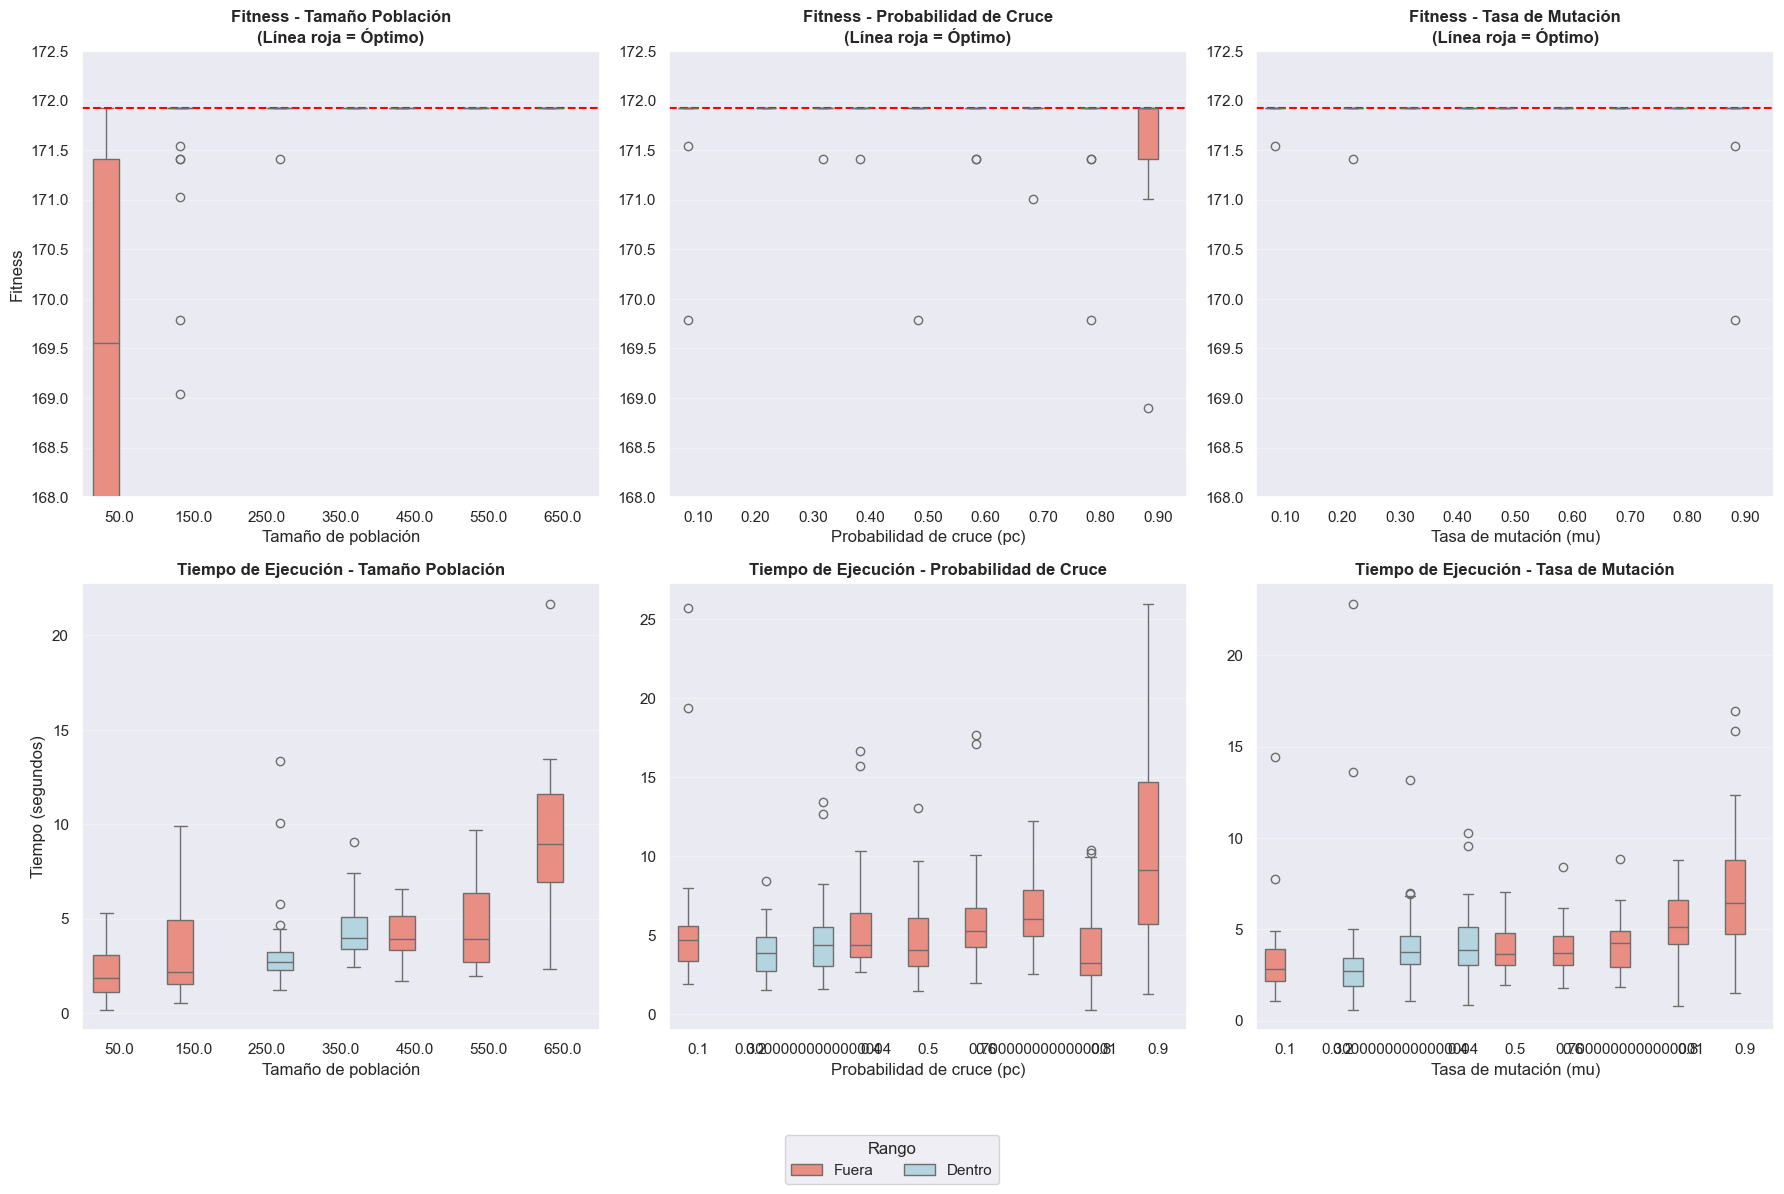


=== Resumen de ejecuciones óptimas ===
Parametro         Valor  en_rango
mu                0.1    Fuera       29
                  0.2    Dentro      29
                  0.3    Dentro      30
                  0.4    Dentro      30
                  0.5    Fuera       30
                  0.6    Fuera       30
                  0.7    Fuera       30
                  0.8    Fuera       30
                  0.9    Fuera       28
pc                0.1    Fuera       28
                  0.2    Dentro      30
                  0.3    Dentro      29
                  0.4    Fuera       29
                  0.5    Fuera       29
                  0.6    Fuera       28
                  0.7    Fuera       29
                  0.8    Fuera       27
                  0.9    Fuera       18
tamano_poblacion  50.0   Fuera        7
                  150.0  Fuera       23
                  250.0  Dentro      29
                  350.0  Dentro      30
                  450.0  Fuera       30
      

In [33]:
# Ejecutar análisis completo
df_resultados = analisis_sensibilidad()

# Guardar resultados
df_resultados.to_csv("resultados_completos.csv", index=False)

# Análisis estadístico
analisis_estadistico(df_resultados)

# Visualización
visualizacion(df_resultados)

# Resumen ejecuciones que alcanzaron el óptimo
print("\n=== Resumen de ejecuciones óptimas ===")
print(df_resultados.groupby(['Parametro', 'Valor', 'en_rango'])['alcanzo_optimo'].sum())


=== Análisis por Parámetro ===

---- TAMANO_POBLACION ----
FITNESS - H: 11.589, p-valor: 0.0007
TIEMPO - H: 0.851, p-valor: 0.3562

Resumen estadístico:
         mejor_fitness           tiempo_ejecucion           alcanzo_optimo
                  mean       std             mean       std            sum
en_rango                                                                  
Dentro      171.910479  0.065455         3.849612  2.097688             59
Fuera       171.308198  1.600692         4.705232  3.414649            120

---- PC ----
FITNESS - H: 4.687, p-valor: 0.0304
TIEMPO - H: 10.469, p-valor: 0.0012

Resumen estadístico:
         mejor_fitness           tiempo_ejecucion           alcanzo_optimo
                  mean       std             mean       std            sum
en_rango                                                                  
Dentro      171.910479  0.065455         4.367234  2.236313             59
Fuera       171.780991  0.611303         6.168994  4.270921    

C:\Users\mar\AppData\Local\Temp\ipykernel_4456\4044607646.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{float(x.get_text()):.2f}" for x in ax.get_xticklabels()])
C:\Users\mar\AppData\Local\Temp\ipykernel_4456\4044607646.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{float(x.get_text()):.2f}" for x in ax.get_xticklabels()])


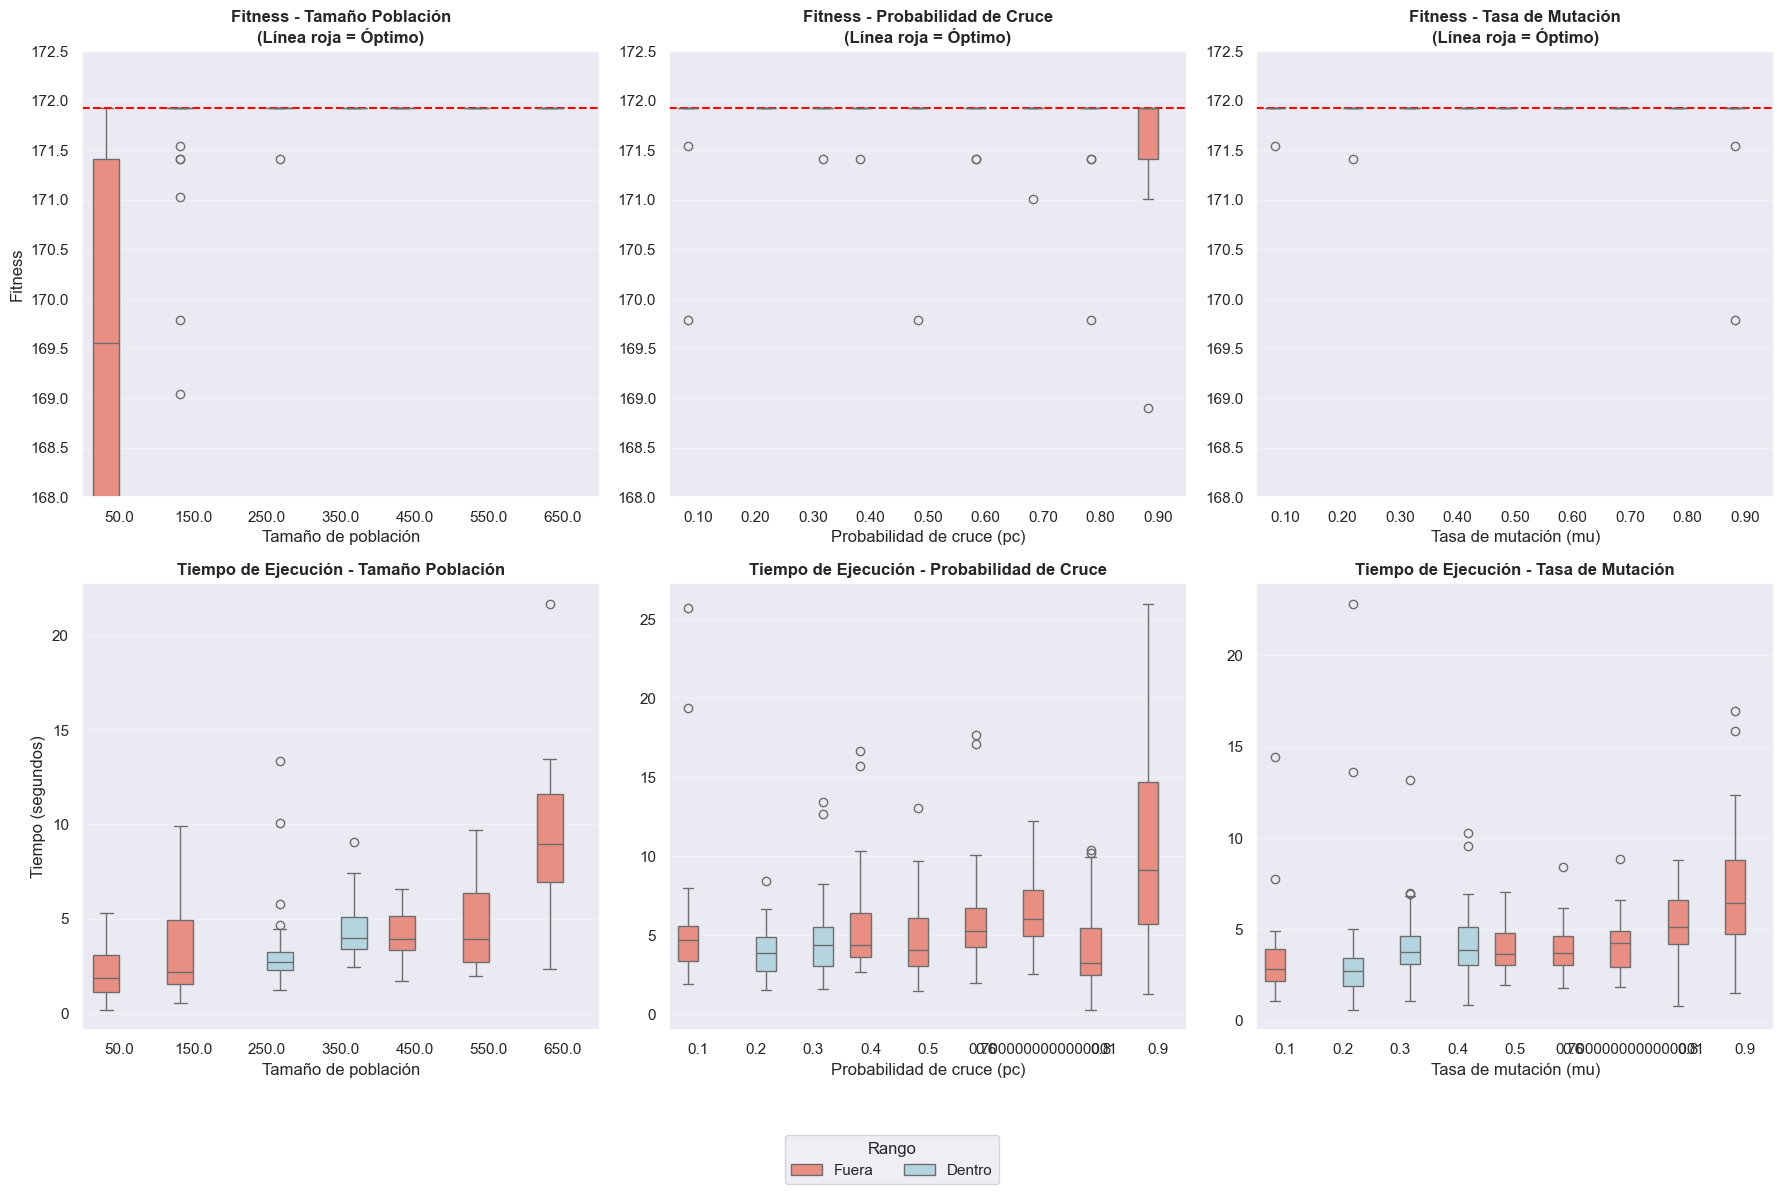


=== Resumen de ejecuciones óptimas ===
Parametro         Valor  en_rango
mu                0.1    Fuera       29
                  0.2    Dentro      29
                  0.3    Dentro      30
                  0.4    Dentro      30
                  0.5    Fuera       30
                  0.6    Fuera       30
                  0.7    Fuera       30
                  0.8    Fuera       30
                  0.9    Fuera       28
pc                0.1    Fuera       28
                  0.2    Dentro      30
                  0.3    Dentro      29
                  0.4    Fuera       29
                  0.5    Fuera       29
                  0.6    Fuera       28
                  0.7    Fuera       29
                  0.8    Fuera       27
                  0.9    Fuera       18
tamano_poblacion  50.0   Fuera        7
                  150.0  Fuera       23
                  250.0  Dentro      29
                  350.0  Dentro      30
                  450.0  Fuera       30
      

In [42]:
# Guardar resultados
df_resultados = pd.read_csv("resultados_completos.csv")

# Análisis estadístico
analisis_estadistico(df_resultados)

# Visualización
visualizacion(df_resultados)

# Resumen ejecuciones que alcanzaron el óptimo
print("\n=== Resumen de ejecuciones óptimas ===")
print(df_resultados.groupby(['Parametro', 'Valor', 'en_rango'])['alcanzo_optimo'].sum())

In [ ]:
def analisis_sensibilidad():
    resultados = []
    
    # Función auxiliar para añadir resultados
    def agregar_resultado(param, valor, resultado, rango_ideal):
        resultados.append({
            "Parametro": param,
            "Valor": valor,
            "run": run,
            "mejor_fitness": resultado["mejor_fitness"],
            "tiempo_ejecucion": resultado["tiempo_ejecucion"],
            "generaciones": resultado["generaciones"],
            "alcanzo_optimo": resultado["alcanzo_optimo"],
            "en_rango": "Dentro" if rango_ideal[0] <= valor <= rango_ideal[1] else "Fuera"
        })
    
    # 1. Variar tamaño de población
    print("Variando tamaño de población...")
    for tamanoPoblacion in tqdm(tamano_poblacion_values):
        for run in range(repeticiones):
            resultado = ejecutar_algoritmo_genetico(tamanoPoblacion, 0.3, 0.3)
            agregar_resultado("tamano_poblacion", tamanoPoblacion, resultado, (250, 350))
    
    # 2. Variar probabilidad de cruce
    print("Variando probabilidad de cruce...")
    for pc in tqdm(pc_values):
        for run in range(repeticiones):
            resultado = ejecutar_algoritmo_genetico(250, pc, 0.3)
            agregar_resultado("pc", pc, resultado, (0.2, 0.35))
    
    # 3. Variar tasa de mutación
    print("Variando tasa de mutación...")
    for mu in tqdm(mu_values):
        for run in range(repeticiones):
            resultado = ejecutar_algoritmo_genetico(250, 0.3, mu)
            agregar_resultado("mu", mu, resultado, (0.15, 0.35))
    
    return pd.DataFrame(resultados)

# Códgio para las comparaciones

In [37]:
repeticiones = 200

In [40]:
def ga():
    resultados = []
    
    # Función auxiliar para añadir resultados
    def agregar_resultado(resultado):
        resultados.append({
            "Modelo": 'GA',
            "run": run,
            "mejor_fitness": resultado["mejor_fitness"],
            "tiempo_ejecucion": resultado["tiempo_ejecucion"],
            "alcanzo_optimo": resultado["alcanzo_optimo"],
        })
    
    # 1. Variar tamaño de población
    print("Ejecutando GA...")
    for run in range(repeticiones):
        resultado = ejecutar_algoritmo_genetico(250, 0.3, 0.3)
        agregar_resultado(resultado)

    return pd.DataFrame(resultados)

In [41]:
df_resultados_pso = ga()

# Guardar resultados
df_resultados_pso.to_csv("comparacion_prueba.csv", index=False)

Ejecutando GA...
